# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
movies = pd.read_csv("./data/movies.csv")
ratings = pd.read_csv("./data/ratings.csv")

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


# EDA

### Basic data health check

In [7]:

num_users = ratings["userId"].nunique()
num_movies = ratings["movieId"].nunique()
num_ratings = len(ratings)

print(f"Unique users: {num_users}")
print(f"Unique movies rated: {num_movies}")
print(f"Total ratings: {num_ratings}")


# Spasity
sparsity = 1 - (num_ratings / (num_users * num_movies))
print(f"Sparsity of the ratings matrix: {sparsity:.4f}")


Unique users: 610
Unique movies rated: 9724
Total ratings: 100836
Sparsity of the ratings matrix: 0.9830


98.30% of possible user–movie interactions do not exist

### Interactions per user

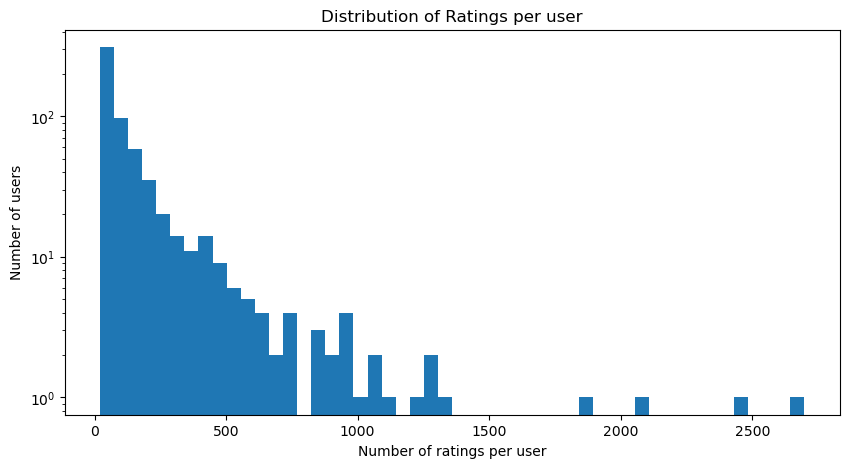

In [8]:

user_counts = ratings.groupby("userId").size()

plt.figure(figsize = (10, 5))

plt.hist(user_counts, bins=50)

plt.xlabel("Number of ratings per user")
plt.ylabel("Number of users")
plt.title("Distribution of Ratings per user")
plt.yscale("log")

plt.show()

### Ratings distribution

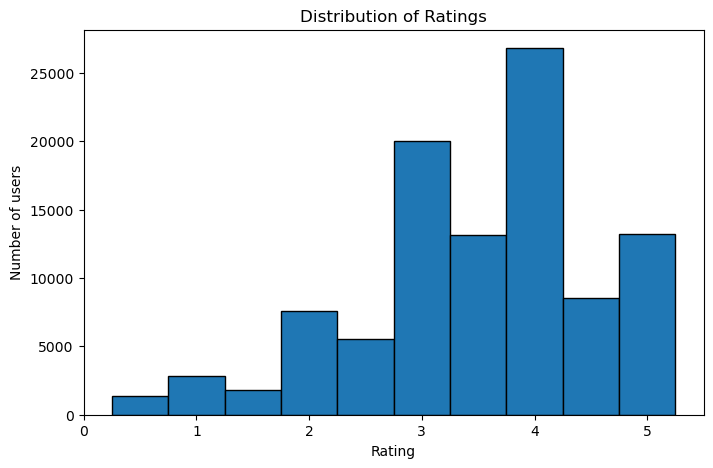

In [9]:
ratings_count = ratings.groupby("rating").size()

plt.figure(figsize = (8, 5))

plt.bar(x = ratings_count.index, height = ratings_count.values, edgecolor = 'black', width = 0.5)

plt.xlabel("Rating")
plt.ylabel("Number of users")
plt.title("Distribution of Ratings")


plt.show()

### Average rating per user

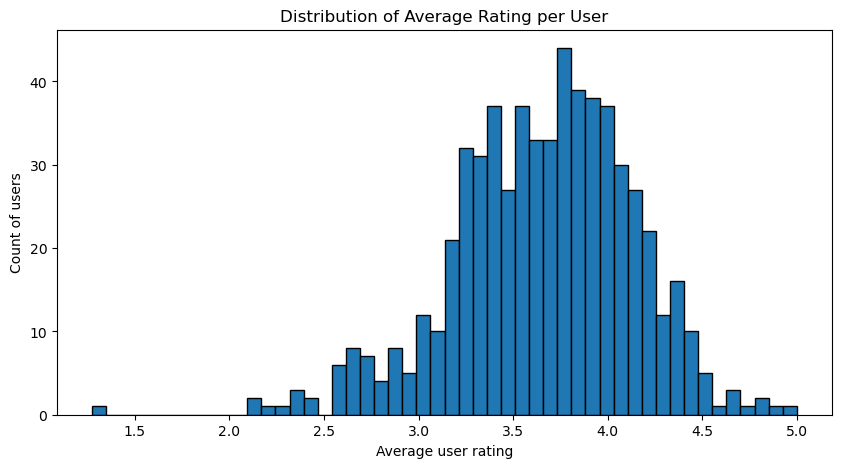

In [10]:
avg_rating = ratings.groupby("userId").mean()["rating"]

plt.figure(figsize=(10, 5))

plt.hist(avg_rating, bins = 50, edgecolor = 'black')

plt.xlabel("Average user rating")
plt.ylabel("Count of users")
plt.title("Distribution of Average Rating per User")

plt.show()

### Movies popularity

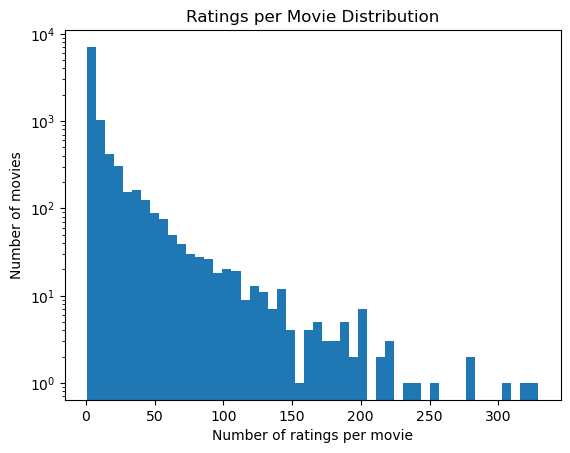

In [11]:
plt.hist(ratings.groupby("movieId").size(), bins = 50)
plt.title("Ratings per Movie Distribution")
plt.xlabel ("Number of ratings per movie")
plt.ylabel ("Number of movies")
plt.yscale("log")

- Many users have very few ratings, few users are extreamely active
- Data shows strong bias towards 3, 4 and 5 ratings. Most of the users average rating given for movies is in between 3.2 and 4
- A few popular movies received tons of ratings. Most movies get very few ratings.

### Removing extreamely rare movies

- Removing Cold-start movies (movies with less than 3 number of ratings) to avoid noice
- These movies will have unstable factorisation vectors and KNN similarities

In [12]:
movie_counts = ratings.groupby('movieId').size()
movies_to_keep = movie_counts[movie_counts>=3].index
filtered_ratings = ratings[ratings["movieId"].isin(movies_to_keep)]


filtered_num_users = filtered_ratings["userId"].nunique()
filtered_num_movies = filtered_ratings["movieId"].nunique()
filtered_num_ratings = len(filtered_ratings)

print(f"Unique users: {num_users}")
print(f"Filtered Unique users: {filtered_num_users}")
print(f"Unique movies rated: {num_movies}")
print(f"Filtered Unique movies rated: {filtered_num_movies}")
print(f"Total ratings: {num_ratings}")
print(f"Filtered Total ratings: {filtered_num_ratings}")

Unique users: 610
Filtered Unique users: 610
Unique movies rated: 9724
Filtered Unique movies rated: 4980
Total ratings: 100836
Filtered Total ratings: 94794


# Splitting the data into train test

- I will be splitting 80% of a user ratings to train and 20% of most recent data into test datasets.
- If user rated less than 2 movies, whole data is included in train dataset.


In [13]:
filtered_ratings = filtered_ratings.sort_values(by = ["userId", "timestamp"])

train_list = []
test_list = []  

for user_id, group in filtered_ratings.groupby("userId"):
    n_ratings = len(group)
    if n_ratings < 2:
        train_list.append(group)  # All ratings go to training set
        continue  
    split_point = int(0.8 * n_ratings)
    train_list.append(group.iloc[:split_point])
    test_list.append(group.iloc[split_point:])

train_data = pd.concat(train_list)
test_data = pd.concat(test_list)

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (75600, 4)
Test data shape: (19194, 4)


### Encoding Train data

In [15]:
train_data = train_data.copy()

train_data['user_idx'] = train_data["userId"].astype("category").cat.codes
train_data["movie_idx"] = train_data["movieId"].astype("category").cat.codes

# Preserving ID mapping
user_map = dict(zip(train_data["userId"], train_data["user_idx"]))
movie_map = dict(zip(train_data["movieId"], train_data["movie_idx"]))
reverse_movie_map = {v: k for k, v in movie_map.items()}


# CSR Matrix

In [16]:
R_train = csr_matrix(
    (train_data["rating"], (train_data["movie_idx"], train_data["user_idx"])), #(Matrix_data, (rows, columns))
    shape = (train_data["movie_idx"].nunique(), train_data["user_idx"].nunique())
)

R_train

<4935x610 sparse matrix of type '<class 'numpy.float64'>'
	with 75600 stored elements in Compressed Sparse Row format>

# CF Item-Based KNN

In [18]:
item_knn = NearestNeighbors(
    metric = 'cosine',
    algorithm = 'brute',
    n_neighbors = 20,
    n_jobs = -1
)

item_knn.fit(R_train)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

# Recomended Similar Movies

In [35]:
# Function to recommended similar movies
def recommended_similar_movies(movie_id:int, top_k:int = 10):
    # If movie id is not in database
    if movie_id not in movie_map:
        print("Movie not found in training data")
        return []
    
    # Note that R_tain has movie_idx, hence needed conversion
    #Taking k+1 as algorithm predits movie_id iteself as best match
    dis, ind = item_knn.kneighbors(R_train[movie_map[movie_id]], n_neighbors=top_k+1) 

    # ind is 2d array
    similar_movieIds = [reverse_movie_map[i] for i in ind[0][1:]]
    return similar_movieIds

# Function to print recomended movie titles
def show_movie_recommendations(movie_id:int, top_k:int = 10):
    rec_ids = recommended_similar_movies(movie_id, top_k)
    rec_titles = movies[movies["movieId"].isin(rec_ids)][["movieId", "title"]]
    return rec_titles


In [36]:
show_movie_recommendations(10, 10)

,movieId,title
126,153,Batman Forever (1995)
138,165,Die Hard: With a Vengeance (1995)
275,316,Stargate (1994)
302,344,Ace Ventura: Pet Detective (1994)
307,349,Clear and Present Danger (1994)
334,377,Speed (1994)
337,380,True Lies (1994)
418,480,Jurassic Park (1993)
507,589,Terminator 2: Judgment Day (1991)
509,592,Batman (1989)


# Evaluation

In [56]:
# Recommedation function for each user

def recomend_for_user (user_id, top_k = 10):
    if user_id not in user_map:
        return[]
    user_idx = user_map[user_id]

    # get all movies user rated
    user_interactions = R_train[:, user_idx].toarray().flatten()
    rated_movie_idxs = np.where(user_interactions>0)[0]   #gives the indexes of array (also movie idx) where UI>0
    
    # Find all recomended movies of these indexes
    scores = np.zeros(train_data['movie_idx'].nunique())  #Going to store added similarity scores for each movie
    for m in rated_movie_idxs:
        distances, indices = item_knn.kneighbors(R_train[m], n_neighbors=21)
        sims = 1-distances.flatten()[1:]  #Since algorithm computes cosine similarity subtracting from 1
        neighbors = indices.flatten()[1:]  

        scores[neighbors] += sims

    #Remove already watched movies (rated movies)
    scores[rated_movie_idxs] =-np.inf #subtracting infinity

    top_movie_idxs = np.argsort(scores)[-top_k:][::-1] #sorts low to high hence reversed

    top_movie_ids = [reverse_movie_map[m] for m in top_movie_idxs]

    return top_movie_ids

In [59]:
test_grouped = test_data.groupby("userId")["movieId"].apply(list)


### Metric Functions

In [65]:
def hit_rate_at_k(recommended, test_items):
    return int(any(item in recommended for item in test_items))


def recall_at_k(recommended, test_items):
    hits = sum(item in recommended for item in test_items)
    return hits/len(test_items)

def ndcg_at_k(recommended, test_items):
    dcg = 0
    for i, item in enumerate(recommended):
        if item in test_items:
            dcg += 1/np.log2(i+2)
    idcg = sum([1/np.log2(i+2) for i in range(min(len(test_items), len(recommended)))])
    return dcg/idcg if idcg>0 else 0

### Evaluating

In [67]:
k = 10

hit_scores = []
recall_scores = []
ndcg_scores = []

for user in test_grouped.index:
    recommended = recomend_for_user(user, k)
    test_items = test_grouped[user]

    hit_scores.append(hit_rate_at_k(recommended, test_items))
    recall_scores.append(recall_at_k(recommended, test_items))
    ndcg_scores.append(ndcg_at_k(recommended, test_items))

print(f"Hit@{k}:    {np.mean(hit_scores):.4f}")
print(f"Recall@{k}: {np.mean(recall_scores):.4f}")
print(f"NDCG@{k}:   {np.mean(ndcg_scores):.4f}")


Hit@10:    0.5311
Recall@10: 0.0638
NDCG@10:   0.1219
